In [13]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import datasets

from evaluation.embeddings_generator import EmbeddingsGenerator

In [2]:
eval_loc = 'scirepeval_results.json'
measure_name = 'i_10'
measure_loc = f'data/s2ag/{measure_name}_1781-2022.csv.gz'

dsets = [
        #  'scidocs_view_cite_read', 
        #  'scidocs_mag_mesh',
         'pub_year',
        #  'cite_count'
         ]

In [3]:
impact = pd.read_csv(measure_loc)
impact.head()

,record_id,i_10
0,52936046.0,0
1,52937917.0,0
2,52936664.0,0
3,88427352.0,0
4,94110275.0,0


In [4]:
maps = []
for dset in dsets:
    maps.append(datasets.load_dataset('allenai/scirepeval', dset)['evaluation'].to_pandas())
map = pd.concat(maps)
map.head()

,doc_id,corpus_id,title,abstract,year,venue,norm_year,scaled_year,n_authors,norm_authors
0,164554770,164554770,Association of sport and recreational faciliti...,"Abstract The Sport Policy of Ethiopia, declare...",2019,Sport in Society,0.812,3.02064,3,-0.207
1,22351519,22351519,Information Technology and Firm Profitability:...,Do information technology investments improve ...,2012,MIS Q.,0.375,1.39500,4,0.037
2,20078386,20078386,Patient access to medical records and healthca...,OBJECTIVES We conducted a systematic review to...,2014,J. Am. Medical Informatics Assoc.,0.500,1.86000,5,0.281
3,213871857,213871857,EXPERIMENTAL APPROACH FOR UNDERSTANDING THE DY...,"In Japan, as in other countries, bentonite bas...",2019,,0.812,3.02064,4,0.037
4,109366645,109366645,SOLUSI MURAH DAN MUDAH UNTUK MENDAPATKAN GAINT...,Penelitian Ilmiah ini menitik beratkan pada pe...,2009,,0.188,0.69936,1,-0.694


In [5]:
embeddings = []
for dset in dsets:
    embs = EmbeddingsGenerator.load_embeddings_from_jsonl(f'embeddings/{dset}.jsonl')
    embs = pd.DataFrame.from_dict(embs, orient='index')
    embeddings.append(embs)
embeddings = pd.concat(embeddings)
print(embeddings.shape)
embeddings = embeddings[~embeddings.index.duplicated(keep='first')]
print(embeddings.shape)
embeddings.head()

reading embeddings from embeddings/pub_year.jsonl: 30000it [00:03, 9228.20it/s]


(30000, 768)
(30000, 768)


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
164554770,-0.677246,-0.375000,-0.751953,0.078735,-0.284668,0.180420,0.235718,-0.280029,-0.885742,0.887207,...,0.376953,-0.748047,0.459717,-1.259766,-2.058594,-0.232544,-0.520508,-0.721680,-0.005180,-0.131104
22351519,-0.345947,0.395752,-1.787109,-0.077271,-0.302734,-0.583984,0.735352,-0.603516,-0.104370,0.055206,...,1.188477,0.312012,-0.770508,-0.545898,-1.176758,-0.305908,-0.382080,-0.423340,-0.842285,-0.111938
20078386,-0.114136,0.461426,-1.235352,-0.698730,-1.054688,-0.874023,-0.160767,1.072266,-0.312256,1.114258,...,-0.193115,0.646484,-0.319336,-0.723633,-0.972168,-0.438232,0.866211,0.469238,-0.058533,-0.009323
213871857,-0.315918,-0.373535,-0.001995,-0.013672,-0.034088,-0.297119,0.180908,0.277344,0.025253,1.250977,...,0.764648,-0.821777,-0.803711,-0.921387,-1.735352,-0.011124,-0.395996,-0.776367,-0.804688,0.229614
109366645,-0.637695,0.113098,0.291260,-0.131958,-0.037598,-0.554199,0.133911,-1.454102,-0.342773,1.060547,...,0.759277,-0.143677,-0.273682,-0.669922,-1.639648,-1.100586,-0.250977,-0.826172,0.264893,-0.678711


In [6]:
def cosine_sim_torch(x1, x2=None, eps=1e-8):
    x2 = x1 if x2 is None else x2
    w1 = x1.norm(p=2, dim=1, keepdim=True)
    w2 = w1 if x2 is x1 else x2.norm(p=2, dim=1, keepdim=True)
    return torch.mm(x1, x2.t()) / (w1 * w2.t()).clamp(min=eps)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sims = cosine_sim_torch(torch.tensor(embeddings.values).to(device))
sims = pd.DataFrame(sims.cpu().numpy(), index=embeddings.index, columns=embeddings.index)
torch.cuda.empty_cache()
sims.head()

,164554770,22351519,20078386,213871857,109366645,237199126,99442189,211839087,1498445,119117161,...,167001249,148301364,6500606,165760952,158029679,213296711,221623014,145720214,51923936,191091958
164554770,1.000977,0.687988,0.687012,0.713867,0.668945,0.720215,0.675781,0.740234,0.646973,0.579102,...,0.715332,0.756348,0.745117,0.745605,0.765625,0.666016,0.639160,0.703125,0.596680,0.772461
22351519,0.687988,1.000000,0.746582,0.657227,0.617188,0.729004,0.658203,0.662598,0.676270,0.576172,...,0.704590,0.644531,0.638672,0.770020,0.725098,0.600098,0.598145,0.664551,0.560059,0.714355
20078386,0.687012,0.746582,1.000000,0.645020,0.594238,0.747070,0.651855,0.737305,0.667480,0.585938,...,0.685059,0.680664,0.635254,0.706055,0.686523,0.603516,0.699219,0.675781,0.611816,0.707031
213871857,0.713867,0.657227,0.645020,1.000000,0.684570,0.639160,0.808594,0.669434,0.625000,0.669434,...,0.707031,0.655762,0.626465,0.660156,0.698730,0.634766,0.712891,0.585449,0.600586,0.745605
109366645,0.668945,0.617188,0.594238,0.684570,1.000000,0.626465,0.639160,0.651367,0.633789,0.617188,...,0.674316,0.588867,0.632324,0.659668,0.625977,0.632812,0.645020,0.640625,0.569824,0.761230


In [8]:
with open(eval_loc, 'rb') as f:
    eval_data = json.load(f)

In [9]:
dfs = []
for task in eval_data.keys():
    df = pd.DataFrame.from_dict(eval_data[task], orient='index').unstack().to_frame('value')
    df['task'] = task
    df.index.names = ['metric','doc_id']
    df = df.reset_index().merge(map[['corpus_id','doc_id','year']], on='doc_id')
    dfs.append(df)

df = pd.concat(dfs)
df.head()

,metric,doc_id,value,task,corpus_id,year
0,kendalltau,100695146,-1.827504,Citation Count,100695146,2016
1,kendalltau,100841477,2.849267,Citation Count,100841477,2016
2,kendalltau,10130024,0.451364,Citation Count,10130024,2016
3,kendalltau,101535915,-0.206386,Citation Count,101535915,2016
4,kendalltau,101775309,-0.318630,Citation Count,101775309,2016


In [10]:
merged = df.merge(impact, left_on='corpus_id', right_on='record_id')
merged.head()

,metric,doc_id,value,task,corpus_id,year,record_id,i_10
0,kendalltau,100695146,-1.827504,Citation Count,100695146,2016,100695146.0,42
1,kendalltau,10130024,0.451364,Citation Count,10130024,2016,10130024.0,85
2,kendalltau,101535915,-0.206386,Citation Count,101535915,2016,101535915.0,54
3,kendalltau,101535915,0.674214,Publication Year,101535915,2016,101535915.0,54
4,kendalltau,101775309,-0.318630,Citation Count,101775309,2016,101775309.0,29


/tmp/ipykernel_30335/1700336162.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merged.groupby('year').apply(lambda x: x.corr('spearman')['value'][measure_name]).plot()


<Axes: xlabel='year'>

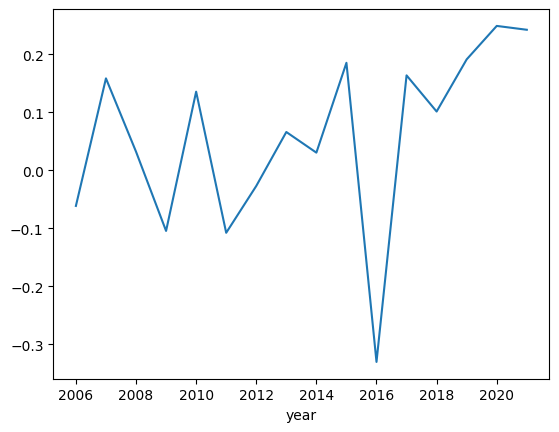

In [11]:
merged.groupby('year').apply(lambda x: x.corr('spearman')['value'][measure_name]).plot()

In [65]:
years = merged['year'].sort_values().unique()
ids = merged['doc_id'].unique()
yearly_sims = pd.DataFrame(index=ids, columns=years)
yearly_sims.index.name = 'doc_id'
yearly_sims.columns.name = 'comp_year'

for ref_year in tqdm(years, desc='ref year'):
    ref_papers = merged[merged['year'] == ref_year]['doc_id'].unique()
    for comp_year in years:
        comp_papers = merged[merged['year'] == comp_year]['doc_id'].unique()
        yearly_sims.loc[ref_papers, comp_year] = sims.loc[ref_papers, comp_papers].mean(axis=1)

ref year: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]


In [66]:
yearly_sims

comp_year,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
doc_id,,,,,,,,,,,,,,,,
100695146,0.685547,0.683594,0.685059,0.67334,0.675781,0.680664,0.669434,0.678711,0.672852,0.669922,0.669434,0.663086,0.663086,0.663086,0.65918,0.641602
10130024,0.660645,0.657715,0.653809,0.655273,0.658691,0.657227,0.646973,0.657715,0.646973,0.648926,0.649902,0.644043,0.645508,0.640625,0.647461,0.644043
101535915,0.68457,0.685059,0.685059,0.679688,0.680664,0.679688,0.668457,0.678223,0.672363,0.669434,0.672363,0.665039,0.66748,0.667969,0.663574,0.646484
101775309,0.694336,0.687012,0.686523,0.685059,0.684082,0.679688,0.671875,0.68457,0.673828,0.673828,0.674805,0.668457,0.667969,0.668945,0.665527,0.655273
1031734,0.658203,0.648926,0.648926,0.650391,0.651855,0.657715,0.645996,0.651367,0.651855,0.644043,0.643066,0.640625,0.641602,0.635742,0.630371,0.609863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981946,0.689453,0.694336,0.688477,0.686035,0.69043,0.68457,0.681641,0.68457,0.680176,0.678223,0.678223,0.673828,0.671387,0.669434,0.668945,0.652344
99835691,0.723633,0.726562,0.72168,0.716797,0.71582,0.713867,0.710449,0.719238,0.709961,0.710938,0.712402,0.705078,0.705078,0.70459,0.707031,0.702148
9987911,0.657227,0.655762,0.645508,0.641113,0.645508,0.65332,0.647949,0.651855,0.646484,0.65332,0.652344,0.646484,0.65332,0.648926,0.661133,0.679688


In [67]:
yearly_sims.pct_change(axis=1).stack().to_frame('return')

return
doc_id    comp_year          
100695146 2007      -0.002849
          2008       0.002143
          2009      -0.017106
          2010       0.003626
          2011       0.007225
...                       ...
9995869   2017      -0.004418
          2018      -0.001479
          2019      -0.008148
          2020       0.008962
          2021      -0.017765

[81165 rows x 1 columns]

In [85]:
merged_sims = yearly_sims.pct_change(axis=1).stack().to_frame('return').reset_index().merge(merged[['doc_id','year',measure_name]], on='doc_id').set_index(['doc_id','comp_year','year']).sort_values(by='i_10', ascending=False).sort_index(level=['doc_id','comp_year'], ascending=True)
merged_sims

return  i_10
doc_id   comp_year year                
10009985 2007      2013 -0.020984     6
         2008      2013  0.013304     6
         2009      2013 -0.004376     6
         2010      2013  0.008059     6
         2011      2013 -0.010901     6
...                           ...   ...
9995869  2017      2016 -0.004418   668
         2018      2016 -0.001479   668
         2019      2016 -0.008148   668
         2020      2016  0.008962   668
         2021      2016 -0.017765   668

[81960 rows x 2 columns]

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 [Text(-2.0, 0, '(2020, 2018)'),
  Text(0.0, 0, '(2007, 2018)'),
  Text(2.0, 0, '(2009, 2018)'),
  Text(4.0, 0, '(2011, 2018)'),
  Text(6.0, 0, '(2013, 2018)'),
  Text(8.0, 0, '(2015, 2018)'),
  Text(10.0, 0, '(2017, 2018)'),
  Text(12.0, 0, '(2019, 2018)'),
  Text(14.0, 0, '(2021, 2018)'),
  Text(16.0, 0, '')])

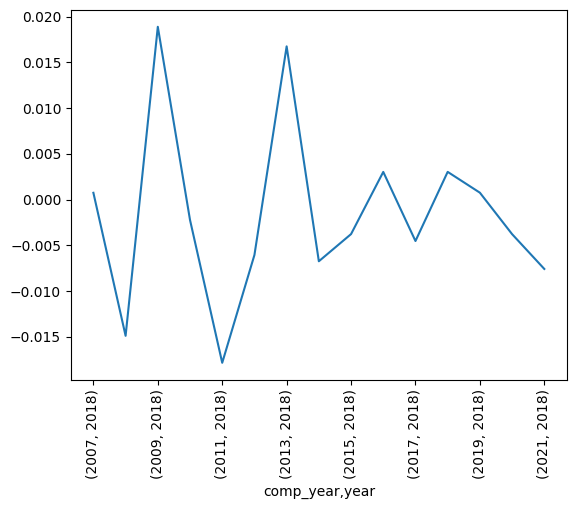

In [95]:
merged_sims.loc[merged_sims.index.get_level_values(0)[1000]]['return'].plot()
plt.xticks(rotation=90)